# SINDy

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/ML-DS-Workshop-23/projects/SINDy`


# Contents
1. [SINDy: Sparse Identification of Nonlinear Dynamics](#sindy)
2. [Beyond SINDy: Genetic Algorithms and Neural ODEs](#neural-odes)
3. [Project Suggestions](#projects)
4. [Further Reading](#further-reading)

# 1. SINDy: Sparse Identification of Nonlinear Dynamics <a class="anchor" id="sindy"></a>

- SINDy ([Brunton et al. 2016](https://www.pnas.org/doi/10.1073/pnas.1517384113)) bypasses the intractable combinatorial search through all possible model structures by leveraging the fact that many dynamical systems,

$$\mathbf{\dot{x}}(t) = \mathbf{f}(\mathbf{x}(t)),$$

where $\mathbf x \in \mathbb{R}^n$, have only a few active terms in the space of all possible right-hand side functions $\mathbf{f}$. (For ease of notation, and without less of generality, we will restrict our attention to autonomous dynamical systems.)
<br>

- For example, the Lorenz system,

$$
\begin{aligned} 
\dot{x} &= \sigma(y-x) \\ 
\dot{y} &= x(\rho-z)  -y \\ 
\dot{z} &= xy - \beta z ,
\end{aligned}
$$

possesses only a handful of terms, all of which are either linear or quadratic in $x,y,z$.

- SINDy therefore attempts to fit a **sparse** model of the form,

$$\dot{x}_k = f_k(\mathbf x) = \Theta(\mathbf x^T) \mathbf\xi_k,$$

where $k = 1, 2, \ldots, n$ denotes the component of $\mathbf f$ being modelled, $\Theta(\mathbf x^T)$ is a row vector of symbolic (generally nonlinear) basis functions of the elements of $\mathbf x$, and $\mathbf\xi_k$ is a vector of sparse coefficients.

- The SINDy algorithm thus boils down to choosing an appropriate basis $\Theta$ before solving $n$ independent sparse regression problems for the coefficients $\Xi = [\xi_1 \xi_2 \dots \xi_n]$.
<br>

- When all is said and done, we are left with a model of the form

$$\mathbf{\dot{x}} = \mathbf{f}(\mathbf{x}) \approx \Xi^T ( \Theta(\mathbf{x}^T)) ^T,$$

which can be expanded out in terms of the symbolic basis functions $\Theta$.

- The procedure is nicely summarised by Figure 1 from the paper:

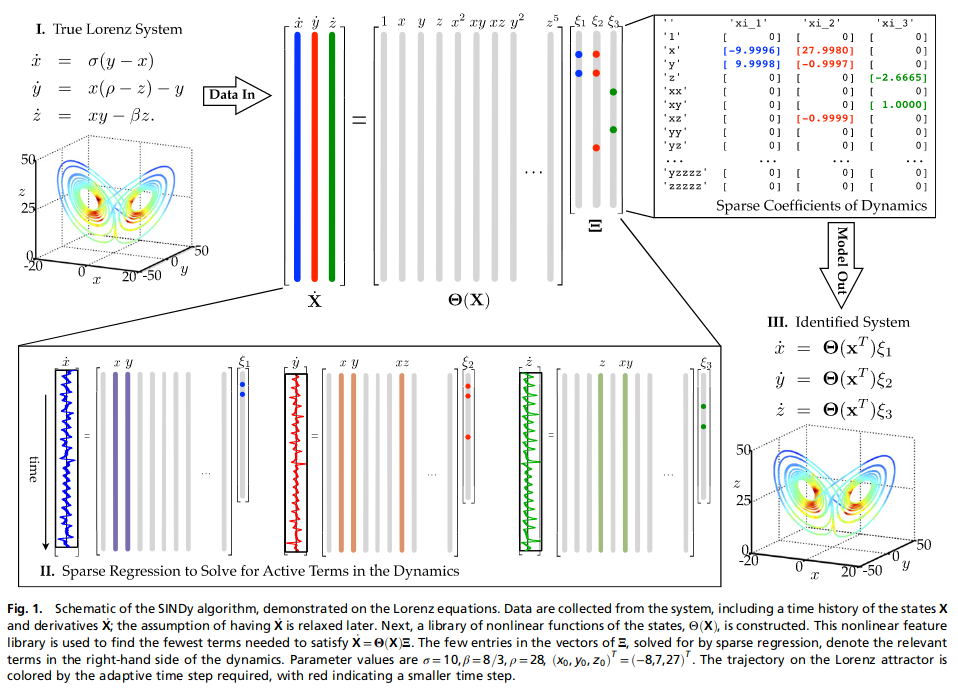

Figure: [Brunton et al. 2016](https://www.pnas.org/doi/10.1073/pnas.1517384113)

- We will now reproduce almost exactly the Lorenz '63 example from [Brunton et al. 2016](https://www.pnas.org/doi/10.1073/pnas.1517384113), demonstrating step-by-step how to solve a SINDy problem in Julia.

In [2]:
using OrdinaryDiffEq      # Numerical ODE integration (this is the ODE part of DifferentialEquations.jl)
using DataDrivenDiffEq    # Generic utilities for data-driven structural identification of ODEs
using DataDrivenSparse    # Specific utilities for identification of sparse ODEs, e.g. SINDy
using DataInterpolations  # Interpolation methods and finite differences for estimating derivatives
using Plots

## Step 0: Generate the Synthetic Training Data

- Before demonstrating SINDy, we need to generate some synthetic data, which will be a good refresher on how to numerically solve ODEs in Julia.

In [3]:
# Set up the RHS with the correct signature (u, p, t) for out-of-place problems
function lorenz(u, p, t)
    x, y, z = u
    σ, ρ, β = p

    dx = σ * (y - x)
    dy = x * (ρ - z) - y
    dz = x * y - β * z
    
    return [dx, dy, dz]
end

lorenz (generic function with 1 method)

In [4]:
# System parameters (standard L63 params)
σ = 10
ρ = 28
β = 8/3
p = [σ, ρ, β]

# Integration parameters (taken directly from the paper)
u0 = [-8, 8, 27]      # Initial conditions
tspan = (0.0, 100.0)  # Start and end time of the integration
dt = 0.001            # Timestep (note how small this is!)

# Solver
alg = Tsit5()         # Tsitouras' 5(4) explicit Runge-Kutta

Tsit5(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false))

In [5]:
# Set up the ODE problem
prob = ODEProblem(lorenz, u0, tspan, p)

# Solve it
sol = solve(prob, alg; saveat = dt)
plot(sol)

## Step 1: Collect the Data

- Given observations of $\mathbf x$ and $\mathbf{\dot x}$ at times $t_1, t_2, \ldots, t_m$, construct two _data matrices_ $\mathbf X$ and $\mathbf{\dot X}$:

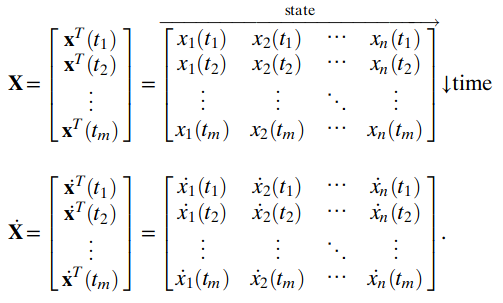

- If measurements of $\mathbf{\dot x}$ are not available, they will have to be estimated numerically from $\mathbf x$, e.g. via finite differences.

In [6]:
X = Array(sol)  # Call the Array constructor on an ODESolution object to put the trajectory into a Matrix

3×100001 Matrix{Float64}:
 -8.0  -7.84088  -7.68352  -7.5279  …   0.438541   0.413498   0.388742
  8.0   7.98356   7.96628   7.9482     -2.08033   -2.07643   -2.07262
 27.0  26.8649   26.7315   26.5999     23.7617    23.6975    23.6336

- Note already that our $\mathbf{X}$ is the transpose of $\mathbf{X}$ as defined in the paper (and in the image above). DataDrivenDiffEq.jl expects the data in this format because Julia arrays are stored in column-major format, making this layout more efficient when accessing the data sequentially.
<br>

- We suppose that we don't have $\mathbf{\dot X}$ and therefore need to estimate it numerically from $\mathbf{X}$.
<br>

- [Brunton et al. 2016](https://www.pnas.org/doi/10.1073/pnas.1517384113) use the _total-variation regularized numerical derivative_ ([Chartrand 2011](https://www.hindawi.com/journals/isrn/2011/164564/)), implemented in the Julia package [NoiseRobustDifferentiation.jl](https://github.com/adrhill/NoiseRobustDifferentiation.jl) as `tvdiff`.
<br>

- Since our present example doesn't include noise, we'll use a simpler method from DataDrivenDiffEq.jl, specifically central finite differences based on linear interpolation. 
<br>

- This can be done using the `collocate_data` method from DataDrivenDiffEq.jl, which also offers many more complex collocation and interpolation schemes. See the [docs](https://docs.sciml.ai/DataDrivenDiffEq/stable/utils/#DataDrivenDiffEq.collocate_data) for further details, and remember that you can always inspect docstrings in Julia by doing e.g. `?collocate_data`.

In [7]:
dX, X, times = collocate_data(X, sol.t, InterpolationMethod(LinearInterpolation))

([159.11910097290337 159.11910097290337 … -25.042732668187952 -24.755812459453498; -16.438756116321507 -16.438756116321507 … 3.8964021371134154 3.812532496727531; -135.1117447517467 -135.1117447517467 … -64.16417680143176 -63.94016188287233], [-8.0 -7.840880899027097 … 0.413498142071824 0.3887423296122523; 8.0 7.9835612438836785 … -2.07643463895464 -2.0726221064578945; 27.0 26.864888255248253 … 23.69753492665405 23.633594764770873], [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009  …  99.991, 99.992, 99.993, 99.994, 99.995, 99.996, 99.997, 99.998, 99.999, 100.0])

- Looks good! So now we have both $\mathbf{X}$ and $\mathbf{\dot X}$.

## Step 2: Construct a Library of Candidate Nonlinear Functions

- Given $\mathbf X$, construct a library of candidate functions $\mathbf{\Theta{(X)}}$,

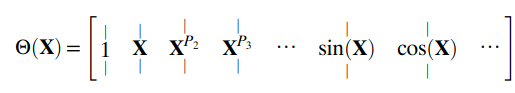

where, for example, $\mathbf{X}^{P_i}$ denotes all polynomials of degree $i$, i.e.

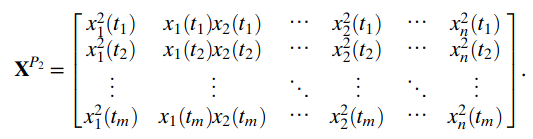

- You have complete freedom to construct $\mathbf{\Theta{(X)}}$ as you see fit! Common choices of candidate basis functions would include constant, polynomial, and trigonometric terms, but you can add columns for any functions you like.
<br>

- The basis is constructed as a vector of symbolic variable expressions and then passed to the `Basis` constructor of DataDrivenDiffEq.jl.

In [8]:
# First we set up the symbolic variables
@variables t x(t) y(t) z(t)  # Symbolic (algebraic) variables, implemented in Symbolics.jl
vars = [x, y, z]
independent_var = t;

In [9]:
# Then we can transform them
sin.(vars)  # e.g. sin basis

3-element Vector{Num}:
 sin(x(t))
 sin(y(t))
 sin(z(t))

In [10]:
[vars; vars.^2]  # e.g. the variables and their squares

6-element Vector{Num}:
   x(t)
   y(t)
   z(t)
 x(t)^2
 y(t)^2
 z(t)^2

- Fortunately DataDrivenDiffEq.jl provides some convenience functions for constructing the basis, e.g. `polynomial_basis` and `fourier basis`.
<br>

- Again following [Brunton et al. 2016](https://www.pnas.org/doi/10.1073/pnas.1517384113), we will use polynomials up to degree 5, storing them in a `Basis` object defined in and required by DataDrivenDiffEq.jl.
<br>

In [11]:
@variables t x(t) y(t) z(t)  # Symbolic (algebraic) variables, implemented in Symbolics.jl
vars = [x, y, z]
degree = 5
independent_var = t
basis = Basis(polynomial_basis(vars, degree), vars, iv = independent_var)

Model ##Basis#328 with 56 equations
States (3):
  x(t)
  y(t)
  z(t)
Parameters (0):

- So we have 56 basis functions, consisting of all polynomials in $x,y,z$ up to and including degree 5.
<br>

- See the [docs](https://docs.sciml.ai/DataDrivenDiffEq/stable/basis/) for more options for constructing the basis.

## Step 3: Set Up the Optimiser

- A standard sparse regression method you might already be familiar with is [Lasso](https://en.wikipedia.org/wiki/Lasso_(statistics)), which imposes an $l_1$ norm penalty on the regression coefficients. This would probably do the job, but it may be slow for large amounts of data.
<br>

- Instead, [Brunton et al. 2016](https://www.pnas.org/doi/10.1073/pnas.1517384113) use a _sequentially thresholded least squares_ algorithm, which consists of the following steps:
    1. Begin with a standard least-squares solution for $\mathbf{\xi}$.
    2. Set all coefficients with magnitude less than the threshold parameter $\lambda$ equal to zero.
    3. Repeat the least-squares solution on the remaining "active" variables.
    4. Return to step 2 (terminating when the non-zero coefficients have converged).<br>
<br>
- The algorithm is implemented as `STLSQ` in DataDrivenSparse.jl.

In [12]:
threshold = 0.05
optimiser = STLSQ(threshold)

STLSQ{Float64, Float64}(0.05, 0.0)

## Step 4: Set Up the Sparse Regression Problem

- Given $\mathbf{\dot{X}}$ and $\mathbf{\Theta{(X)}}$, and our prior that only a few of the candidate functions will be "active" in each component of $\mathbf{f}$, we can set up a sparse regression problem of the form

$$\mathbf{\dot{X}} = \mathbf{\Theta{(X)}}\mathbf{\Xi},$$

where $\mathbf{\Xi} = [\mathbf{\xi_1} \; \mathbf{\xi_2} \cdots \mathbf{\xi_n}]$ are the sparse coefficients to be determined.

- We will solve this row-by-row, i.e. we actually have $n$ independent sparse regression problems.
<br>


- We simply call the `ContinuousDataDrivenProblem` constuctor with the data.

In [13]:
dd_prob = ContinuousDataDrivenProblem(
    X,
    times,
    dX,
)

Continuous DataDrivenProblem{Float64} ##DDProblem#331 in 3 dimensions and 100001 samples

- Note that, for convenience, instead of explicitly using the `collocate_data` method to get dX, as we did in step 1, we could have automated things a bit by directly passing the interpolation method to the `ContinuousDataDrivenProblem` constructor, i.e.

In [14]:
# dd_prob = ContinuousDataDrivenProblem(
#    X, 
#    t,
#    InterpolationMethod(LinearInterpolation)
#)

## Step 5: Solve the Sparse Regression Problem

- All that's left is to call `solve` on the `DataDrivenProblem` object, along with the basis and optimiser.

In [15]:
dd_sol = solve(dd_prob, basis, optimiser, options = DataDrivenCommonOptions(digits = 2))
dd_sol.basis

Model ##Basis#332 with 3 equations
States (3):
  x(t)
  y(t)
  z(t)
Parameters (7):
  p₁
  p₂
  p₃
  p₄
  p₅
  p₆
⋮

In [16]:
dd_sol.prob.p

7-element Vector{Float64}:
 -9.98
  9.99
 27.67
 -0.85
 -0.99
  0.99
 -2.66

- Not bad, but the parameters could be more accurate. Can we already do better using a higher-order interpolation method, e.g. cublic splines?

In [17]:
dd_prob = ContinuousDataDrivenProblem(
    X, 
    times,
    InterpolationMethod(CubicSpline)
)

Continuous DataDrivenProblem{Float64} ##DDProblem#336 in 3 dimensions and 100001 samples

In [39]:
dd_sol = solve(dd_prob, basis, optimiser, options = DataDrivenCommonOptions(digits = 2))
dd_sol.basis

Model ##Basis#897 with 3 equations
States (3):
  x(t)
  y(t)
  z(t)
Parameters (7):
  p₁
  p₂
  p₃
  p₄
  p₅
  p₆
⋮

In [40]:
dd_sol.prob.p

7-element Vector{Float64}:
 -9.99
  9.99
 27.92
 -0.97
 -0.99
  0.99
 -2.66

- Still not perfect, but much better!

# 2. Beyond SINDy: Genetic Algorithms and Neural ODEs <a class="anchor" id="neural-odes"></a>

In [20]:
using OrdinaryDiffEq      # Numerical ODE integration
using Flux                # Neural networks
using Zygote              # Reverse-mode automatic differentiation (part of Flux)
using Optimisers          # Gradient-based optimisation (part of Flux)
using SciMLSensitivity    # Sensitivity algorithms, e.g. adjoint methods
using SymbolicRegression  # Genetic algorithms for symbolic regression
using Statistics          # Statistics standard library that ships with Julia
using Plots

- The SINDy algorithm relies on two important assumptions:
    1. We can either observe the derivatives $\mathbf{\dot x}$, or the observations $\mathbf x$ are sufficiently densely packed that $\mathbf{\dot x}$ can be estimated, e.g. via finite differences.
    2. The underlying equations can be expressed as a linear combination of some pre-selected features.
<br><br>

- To get around the first assumption, we can use $\mathbf x$ to learn some $\mathbf f = \mathbf f_{\theta}$ as a neural network, i.e. a neural ODE.
<br>

- To get around the second assumption, we can use a more general symbolic regression algorithm, e.g. the equation search of [SymbolicRegression.jl](https://github.com/MilesCranmer/SymbolicRegression.jl) which is based on [regularised evolution](https://arxiv.org/abs/1802.01548), a kind of [evolutionary algorithm](https://en.wikipedia.org/wiki/Evolutionary_algorithm).
<br>

- [Kidger (2022)](https://arxiv.org/abs/2202.02435) gives a nice demonstration of this approach using the nonlinear oscillator

$$
\begin{equation}
    \begin{aligned}
        \dot x(t) &= \frac{y(t)}{1+y(t)} \\
        \dot y(t) &= \frac{-x(t)}{1+x(t)},
    \end{aligned}
\end{equation}
$$

for $t \in [0, T]$.

- We can immediately see that it would require a lucky choice of basis functions to recover these equations using SINDy.
<br>

- We leave the full solution as an exercise, or the basis of an interesting project!

# 3. Project Suggestions <a class="anchor" id="projects"></a>

1. Apply SINDy, or a more general symbolic regression algorithm, to a problem related to your research.
2. Test the robustness of SINDy as the noise and/or the stepsize is increased. In the original paper they make a big deal of the robustness of the method to relatively high levels of noise, yet always with a very short timestep...
3. Consider a case where the timestep is too large for the derivative to be reliably estimated using finite differences. Use a neural ODE to learn the RHS of the system and sample the derivatives that way. Combine this with a genetic algorithm, e.g. [SymbolicRegression.jl](https://github.com/MilesCranmer/SymbolicRegression.jl), to learn a set of equations where SINDy would struggle, e.g. the nonlinear oscillator from the last section.

# 4. Further Reading <a class="anchor" id="further-reading"></a>
1. [Discovering governing equations from data by sparse identification of nonlinear dynamical systems (Brunton et al. 2016)](https://www.pnas.org/doi/10.1073/pnas.1517384113)
2. [Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control (Brunton et al. 2019)](https://www.cambridge.org/core/books/datadriven-science-and-engineering/77D52B171B60A496EAFE4DB662ADC36E)
3. [YouTube Videos on SINDy](https://www.youtube.com/watch?v=NxAn0oglMVw)
4. [DataDrivenDiffEq.jl](https://github.com/SciML/DataDrivenDiffEq.jl)
5. [SymbolicRegression.jl](https://github.com/MilesCranmer/SymbolicRegression.jl)